<a href="https://colab.research.google.com/github/robcovino/MSDAP_notebooks/blob/main/DimReduction1_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dimensionality reduction -- Principal component analysis

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

---
## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

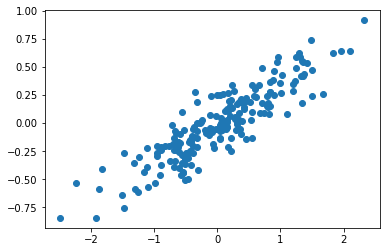

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Q1. Work out what we did to generate the random cloud of 2d data.

Q2. What is the intrinsic dimensionality of the data? 

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.

Q3. Use Scikit-Learn's ``PCA`` estimator to calculate the principal components.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [ ]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

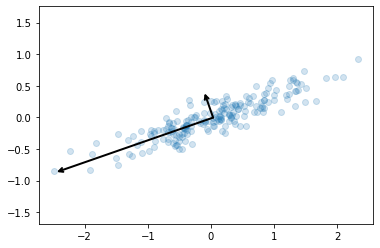

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

This transformation from data axes to principal axes is an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

---
### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Q4. Use the previous example to obtain a reduced version of the same dataset. 

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


Q5. Plot the original and reduced data set to assess how much information you lost. Note that you will have to project or <b> lift </b> the data from the reduced-dimensional representation back to the full dimensional one.

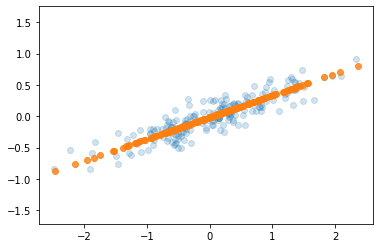

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

---
### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data

In [ ]:
# load the digit data
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Q6. Give a look at the data and understand how they are organized. Helpyourself with the plt.imshow function to plot some of the data entries.

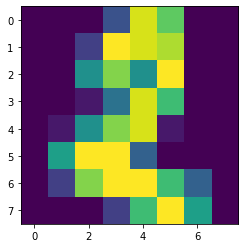

In [ ]:
plt.imshow(digits.data[2].reshape(8,8))

Q7. What is the dimensionality of these data? Use PCA to extract a 2d representation of the data set.

In [ ]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Q8. Adapt the code below to plot the 2dimensional embedding of the digits data set. Discuss the quality of the embedding. An important step is always to check whether the data you got make visual/intuitive sense, and whether they are what you would expect or if instead they are very surprising. 

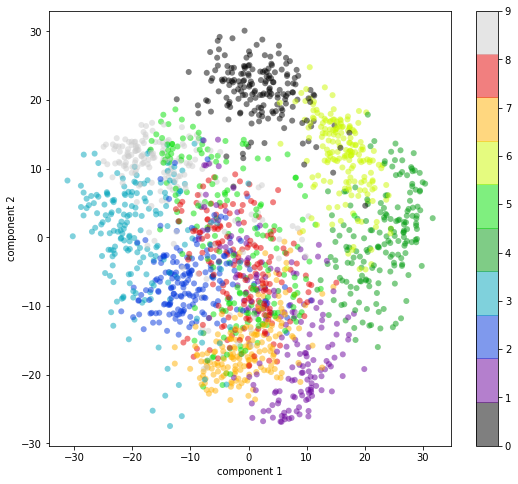

In [ ]:
plt.figure(figsize=(9, 8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components.

Q8. Plot the cumulative explained variance ratio as a function of the components you keep. Do you think that keeping 2 was a good choice? 

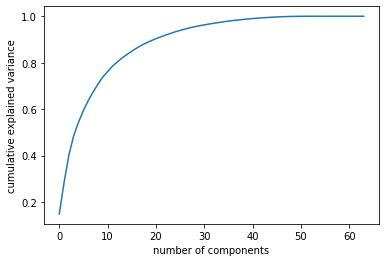

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

---
## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data.

Q9. Insert the data in the plotting function below.

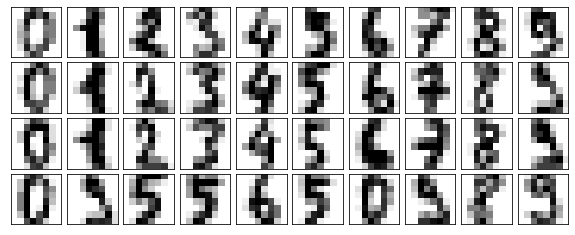

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

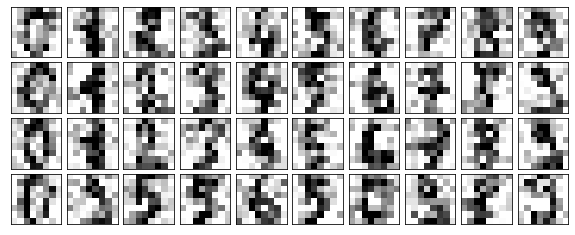

In [ ]:
#np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Q10. Train PCA on the noisy data set, and use the cumulative explained variance criterion to decide how many components to keep. 

In [ ]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

The idea is that by reproducing only the bulk of the variance, we will filter out unenecessary noice from the data. To do this, you must project the original data into the low-dimensional embedding, and then lift them back.

Q11. Use PCA to remove the noise from the noisy digit data set we just created.

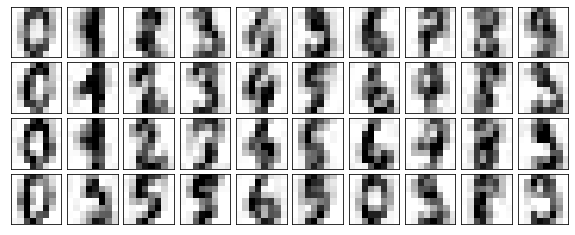

In [ ]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

---
## Introducing the Swiss Roll

Using the code below, generate the next data structure on which to work, which is known as the <b> swiss roll </b>.

In [ ]:
def swiss_roll_2d( n_sample=1000, noise=0.1 ):
  from numpy.random import normal
  theta = np.linspace(0, 3 * np.pi, n_sample)
  R = np.linspace(1, 5, n_sample)
  X = R * np.cos(theta) + normal(scale=noise, size=n_sample)
  Y = R * np.sin(theta) + normal(scale=noise, size=n_sample)
  return np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))

Q11 How are these data organized? Plot them. What does the <b> noise </b> parameter control?

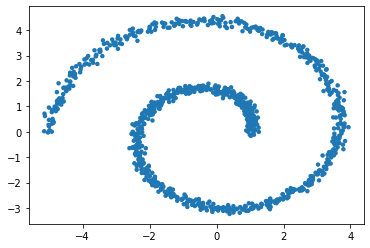

In [ ]:
data = swiss_roll_2d()

plt.scatter(data[:,0], data[:,1], s=20, edgecolor='none')
plt.show()

Q12. What is the intrinsic dimensionality of these data? Try to use the sklearn PCA to perfom dimensionality reduction. Hint: color the original 2d swiss role data according to the 1d PCA variable you discovered.

In [ ]:
pca = PCA(n_components=2)
pca.fit(data)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)

print(pca.explained_variance_ratio_.sum())

[0.56227275 0.43772725]
1.0


In [ ]:
x = pca.transform(data)

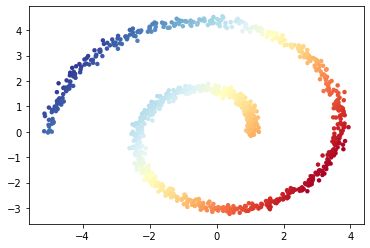

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(data[:,0], data[:,1], c=x[:,0], s=20, cmap=cm, edgecolor='none')
plt.show()

Q13. Was your dimensionality reduction succesful? Can you explain why?

This notebook is based on https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb#scrollTo=tn_wtxGXgGVY